In [1]:
%matplotlib nbagg

Prototype code to calculate fluctuation EM and radial binning efficiently.

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import sparse
import numba

In [3]:
d = np.arange(0, 10, 0.01)
fy, fx = (256, 256)

In [4]:
def weight_smooth(r0, r):
    diff = np.abs(r - r0)
    return np.maximum(0, 1 - diff)

def weight_hard(r0, r):
    return np.abs(r-r0) <= 0.5

<IPython.core.display.Javascript object>


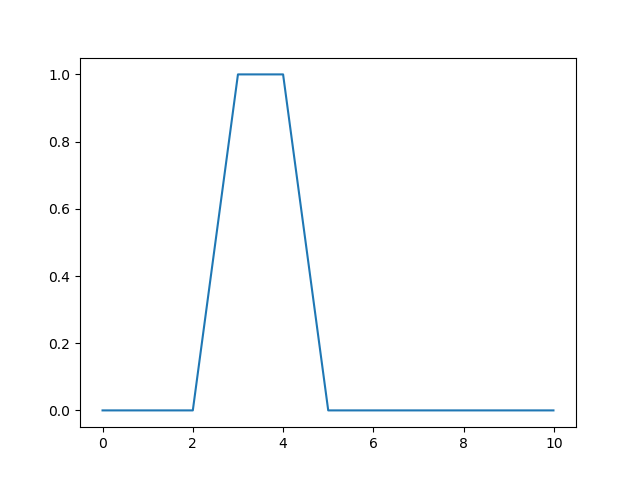

In [5]:
fix, axes = plt.subplots()
plt.plot(d, weight_smooth(3, d) + weight_smooth(4, d))

<IPython.core.display.Javascript object>


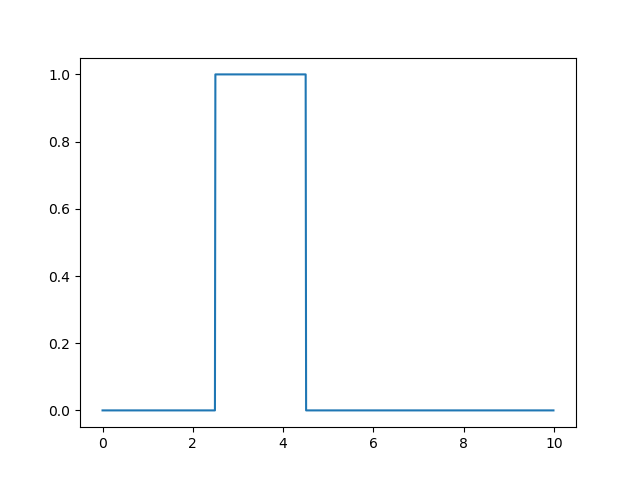

In [6]:
fix, axes = plt.subplots()
plt.plot(d, weight_hard(3, d) + weight_hard(4, d))

In [7]:
y, x = np.ogrid[0:fy, 0:fx]

In [8]:
cy, cx = (fy//2, fx//2)

In [9]:
r = np.sqrt((y - cy)**2 + (x - cx)**2)

<IPython.core.display.Javascript object>


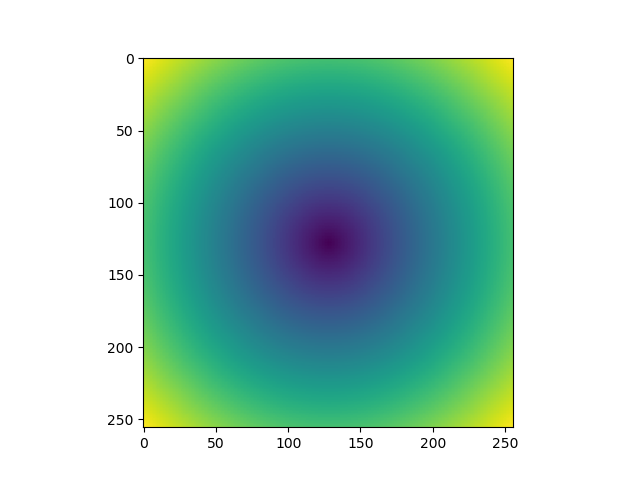

In [10]:
fix, axes = plt.subplots()
plt.imshow(r)

In [11]:
n_bins = int(np.ceil(np.max(r))) + 1

In [12]:
n_bins

183

In [13]:
masks = np.zeros(shape=(n_bins, fy, fx))

In [14]:
for i in range(n_bins):
    masks[i] = weight_smooth(i, r)

In [15]:
m = sparse.COO.from_numpy(masks)

<IPython.core.display.Javascript object>


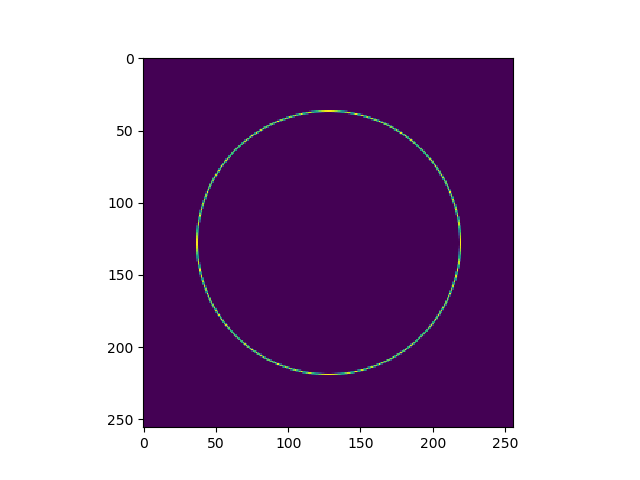

In [16]:
fix, axes = plt.subplots()
plt.imshow(m[n_bins // 2].todense())

In [17]:
data = np.zeros((3, fy, fx))

In [18]:
data[0] = 1

In [19]:
data[1, 0:fy//2, 0:fx//2] = 1

In [20]:
data[2, fy//4:fy//4*3, fx//4:fx//4*3] = 1

In [21]:
def prep_masks_sparse(masks):
    masks = masks.reshape((masks.shape[0], -1))
    n_pixel = masks.sum(axis=1).todense()
    select_non_zero = n_pixel > 0
    calc_masks = masks[select_non_zero]
    calc_n_pixel = n_pixel[select_non_zero]
    sq_masks = np.sqrt(calc_masks)
    return (masks, select_non_zero, calc_masks, calc_n_pixel, sq_masks)
    
def masked_std_sparse(data, masks, select_non_zero, calc_masks, calc_n_pixel, sq_masks):
    std = np.zeros((data.shape[0], masks.shape[0]))
    average = np.zeros((data.shape[0], masks.shape[0]))
    data = data.reshape((data.shape[0], -1))

    average[:, select_non_zero] = sparse.dot(data, calc_masks.T) / calc_n_pixel

    sqsum = np.array([
        ((sq_masks * data[i] - sq_masks * average[i, select_non_zero, np.newaxis])**2).sum(axis=1).todense()
        for i in range(len(data))
    ])
    std[:, select_non_zero] = np.sqrt(sqsum / calc_n_pixel)
    # np.array([]).std() and np.array([]).mean() are nan
    # Calculating with divide by zero would trip the sparse array calculation, for that reason we filter
    # and replicate that behavior here
    std[:, np.invert(select_non_zero)] = np.float('nan')
    average[:, np.invert(select_non_zero)] = np.float('nan')
    return std, average

In [22]:
def prep_masks_sparse_loop(masks):
    masks = masks.reshape((masks.shape[0], -1))
    n_pixel = masks.sum(axis=1).todense()
    sq_masks = np.sqrt(masks)
    return (masks, n_pixel, sq_masks)

def masked_std_sparse_loop(data, masks, n_pixel, sq_masks):
    std = np.zeros((data.shape[0], masks.shape[0]))
    average = np.zeros((data.shape[0], masks.shape[0]))
    data = data.reshape((data.shape[0], -1))
    for i in range(data.shape[0]):
        for j in range(masks.shape[0]):
            if n_pixel[j] == 0:
                average[i, j] = np.float('nan')
                std[i, j] = np.float('nan')
            else:
                average[i, j] = (data[i] * masks[j]).sum()  / n_pixel[j]
                std[i, j] = np.sqrt(((sq_masks[j] * data[i] - sq_masks[j] * average[i, j])**2).sum() / n_pixel[j])
    return std, average

In [23]:
def prep_masks_numpy(masks):
    masks = masks.reshape((masks.shape[0], -1))
    n_pixel = masks.sum(axis=1).todense()
    return (masks, n_pixel)
    
def masked_std_numpy(data, masks, n_pixel):
    std = np.zeros((data.shape[0], masks.shape[0]))
    average = np.zeros((data.shape[0], masks.shape[0]))

    data = data.reshape((data.shape[0], -1))    
    for i in range(data.shape[0]):
        for j in range(masks.shape[0]):
            average[i, j] = np.average(data[i], weights=masks[j].todense())
            v = np.average((data[i] - average[i, j])**2, weights=masks[j].todense())
            std[i, j] = np.sqrt(v)
    return std, average        

In [24]:
# The preparation step takes a considerable amount of time because the mask stack
# is transformed into a compressed format with a list of bins and weight factors
# This may not be an optimal implementation yet
@numba.njit
def prep_masks_numba(masks):
    masks = masks.reshape((masks.shape[0], -1))
    num_stacked = np.zeros(masks.shape[1], dtype=np.int32)
    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            if masks[i, j] != 0:
                num_stacked[j] += 1
    
    depth = np.max(num_stacked)
    bins = np.zeros((np.int64(depth), masks.shape[1]), dtype=np.int32)
    weights = np.zeros((np.int64(depth), masks.shape[1]))
    
    index = np.zeros((masks.shape[1]), dtype=np.int32)
    
    n_pixel = masks.sum(axis=1)

    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            weight = masks[i, j]
            if weight != 0:
                bins[index[j], j] = i
                weights[index[j], j] = weight
                index[j] += 1

    return (n_pixel, masks.shape[0], bins, weights)

# With the compressed format, the processing is transformed into two linear passes
# over the data and the compressed list of bins and weights.
# FIXME For additional cache efficiency, this could be tiled in the i variable
@numba.njit
def masked_std_numba(data, n_pixel, n_masks, bins, weights):
    data = data.reshape((data.shape[0], -1))
    std = np.zeros((data.shape[0], n_masks))
    average = np.zeros((data.shape[0], n_masks))

    for h in range(data.shape[0]):
        for i in range(data.shape[1]):
            for b in range(bins.shape[0]):
                average[h, bins[b, i]] += data[h, i] * weights[b, i]
    average /= n_pixel
    for h in range(data.shape[0]):
        for i in range(data.shape[1]):
            for b in range(bins.shape[0]):
                std[h, bins[b, i]] += (data[h, i] - average[h, bins[b, i]])**2 * weights[b, i]
    std /= n_pixel
    std = np.sqrt(std)
    return std, average

In [25]:
# compile if necessary
prep = prep_masks_sparse(m)
%time prep = prep_masks_sparse(m)

Wall time: 77 ms


In [26]:
# compile if necessary
masked_std_sparse(data, *prep)
%timeit masked_std_sparse(data, *prep)

634 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# compile if necessary
prep = prep_masks_sparse_loop(m)
%time prep = prep_masks_sparse_loop(m)

Wall time: 41 ms


In [28]:
# compile if necessary
masked_std_sparse_loop(data, *prep)
%timeit masked_std_sparse_loop(data, *prep)

3.7 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%time prep = prep_masks_numpy(m)

Wall time: 31 ms


In [30]:
# no compile
%timeit masked_std_numpy(data, *prep)

953 ms ± 55.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# First run for compilation
prep = prep_masks_numba(masks)
%time prep = prep_masks_numba(masks)

Wall time: 259 ms


In [32]:
# First run for compilation
masked_std_numba(data, *prep)
%timeit masked_std_numba(data, *prep)

4.67 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
